In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from utils import roar_data_path as project_data_path
from utils import roar_code_path as project_code_path
from utils import city_list
import gev_city_utils as gevcu
import single_loc_eval as sle

In [2]:
# Set fonts
from matplotlib import font_manager
font_dirs = ["/storage/home/dcl5300/fonts"]

font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.5

### Single location example

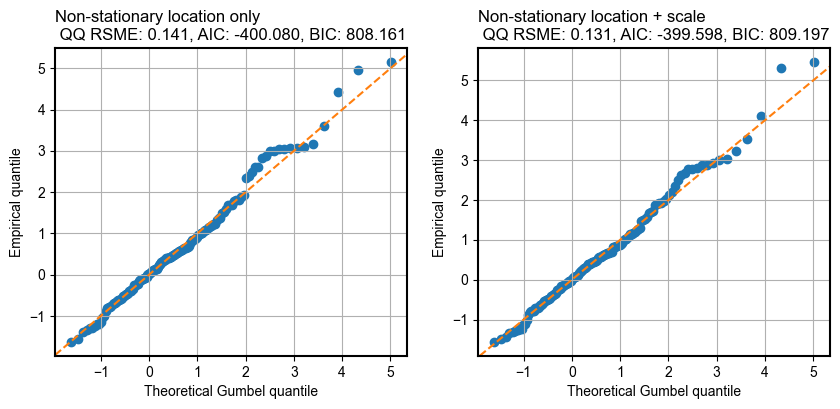

In [5]:
# Read
city = 'stlouis'
metric_id = 'min_tasmin'
df_obs = pd.read_csv(f'{project_data_path}/metrics/cities/{city}_{metric_id}.csv')

# Get all coverage stats
ensemble = 'LOCA2'
gcm = 'ACCESS-CM2'
ssp = 'ssp585'
member = 'r1i1p1f1'

fig, axs = plt.subplots(1,2, figsize=(10,4))

# Nonstat loc
df_fit_nsl = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2100_mle_nonstat_nboot100_samples.csv')
stats_nsl = sle.gev_qq_plot(
                df_fit=df_fit_nsl,
                df_obs=df_obs,
                metric_id=metric_id,
                gcm=gcm,
                ssp=ssp,
                member=member,
                ensemble=ensemble,
                gev_type='nonstat',
                ax=axs[0]
)
axs[0].set_title(f"Non-stationary location only \n QQ RSME: {stats_nsl[0]:.3f}, AIC: {stats_nsl[1]:.3f}, BIC: {stats_nsl[2]:.3f}", loc='left')

# Nonstat loc + scale
df_fit_nsls = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2100_mle_nonstat_scale_nboot100_samples.csv')
stats_nsls = sle.gev_qq_plot(
                df_fit=df_fit_nsls,
                df_obs=df_obs,
                metric_id=metric_id,
                gcm=gcm,
                ssp=ssp,
                member=member,
                ensemble=ensemble,
                gev_type='nonstat_scale',
                ax=axs[1]
)
axs[1].set_title(f"Non-stationary location + scale \n QQ RSME: {stats_nsls[0]:.3f}, AIC: {stats_nsls[1]:.3f}, BIC: {stats_nsls[2]:.3f}", loc='left')
plt.show()

### All cities

In [46]:
# Calculate all
df_stats = []
gev_types = ['nonstat', 'nonstat_scale']

# Metrics
for metric_id in ["max_tasmax", "min_tasmin", "max_pr"]:
    # Cities
    for city in city_list:
        # Read obs
        df_obs = pd.read_csv(f'{project_data_path}/metrics/cities/{city}_{metric_id}.csv')

        # Loop through GEV types
        for gev_type in gev_types:
            # Read fit
            if gev_type == 'stat':
                df_fit = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2014_2050-2100_lmom_stat_nbootproj1000_nboothist1_samples.csv')            
            elif gev_type == 'nonstat':
                df_fit = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2100_mle_nonstat_nboot100_samples.csv')
            elif gev_type == 'nonstat_scale':
                df_fit = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2100_mle_nonstat_scale_nboot100_samples.csv')
            
            # Loop through meta-ensemble members
            combos = df_fit.set_index(["ensemble", "gcm", "member", "ssp"]).sort_index().index.unique()
            for combo in combos:
                ensemble, gcm, member, ssp = combo
                # Calculate stats
                try:
                    stats = sle.gev_qq_plot(
                        df_fit=df_fit,
                        df_obs=df_obs,
                        metric_id=metric_id,
                        gcm=gcm,
                        ssp=ssp,
                        member=member,
                        ensemble=ensemble,
                        gev_type=gev_type,
                        )
                    # Append
                    qq_rmse, log_lik, aic, bic = stats
                    df_stats.append({"city":city,
                                    "metric_id":metric_id,
                                    "ensemble":ensemble,
                                    "gcm":gcm,
                                    "member":member,
                                    "ssp":ssp,
                                    "gev_type":gev_type,
                                    "qq_rmse":qq_rmse,
                                    "log_lik":log_lik,
                                    "aic":aic,
                                    "bic":bic,
                                   })
                except Exception as e:
                    # print(combo)
                    continue

# Concat
df_stats = pd.DataFrame(df_stats).dropna()

/storage/work/dcl5300/current_projects/conus_comparison_lafferty-etal-2024/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/storage/work/dcl5300/current_projects/conus_comparison_lafferty-etal-2024/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/storage/work/dcl5300/current_projects/conus_comparison_lafferty-etal-2024/src/single_loc_eval.py:192: RuntimeWarning: divide by zero encountered in log
  aic = 2 * n_params - 2 * log_lik
/storage/work/dcl5300/current_projects/conus_comparison_lafferty-etal-2024/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/storage/work/dcl5300/current_projects/conus_comparison_lafferty-etal-2024/.venv/lib/python3.12/site-packages/numpy/co

In [47]:
# Merge to get differences 
df_stats_merged = pd.merge(df_stats[df_stats["gev_type"] == "nonstat"],
                          df_stats[df_stats["gev_type"] == "nonstat_scale"],
                          how='inner', on=['gcm', 'ssp', 'ensemble', 'member', 'city', 'metric_id'],
                          suffixes = ('_loc', '_loc-scale'))

df_stats_merged['rmse_diff'] = df_stats_merged['qq_rmse_loc'] - df_stats_merged['qq_rmse_loc-scale']
df_stats_merged['aic_diff'] = df_stats_merged['aic_loc'] - df_stats_merged['aic_loc-scale']
df_stats_merged['bic_diff'] = df_stats_merged['bic_loc'] - df_stats_merged['bic_loc-scale']

In [74]:
# Store fractions preferring location + scale model
df_stats_merged.groupby(['city', 'metric_id']).apply(lambda x: (x[['aic_diff']] < 0).mean(), include_groups=False).to_csv(f'{project_code_path}/data/city_aic_diff_frac_below_zero.csv')
df_stats_merged.groupby(['city', 'metric_id']).apply(lambda x: (x[['bic_diff']] < 0).mean(), include_groups=False).to_csv(f'{project_code_path}/data/city_bic_diff_frac_below_zero.csv')

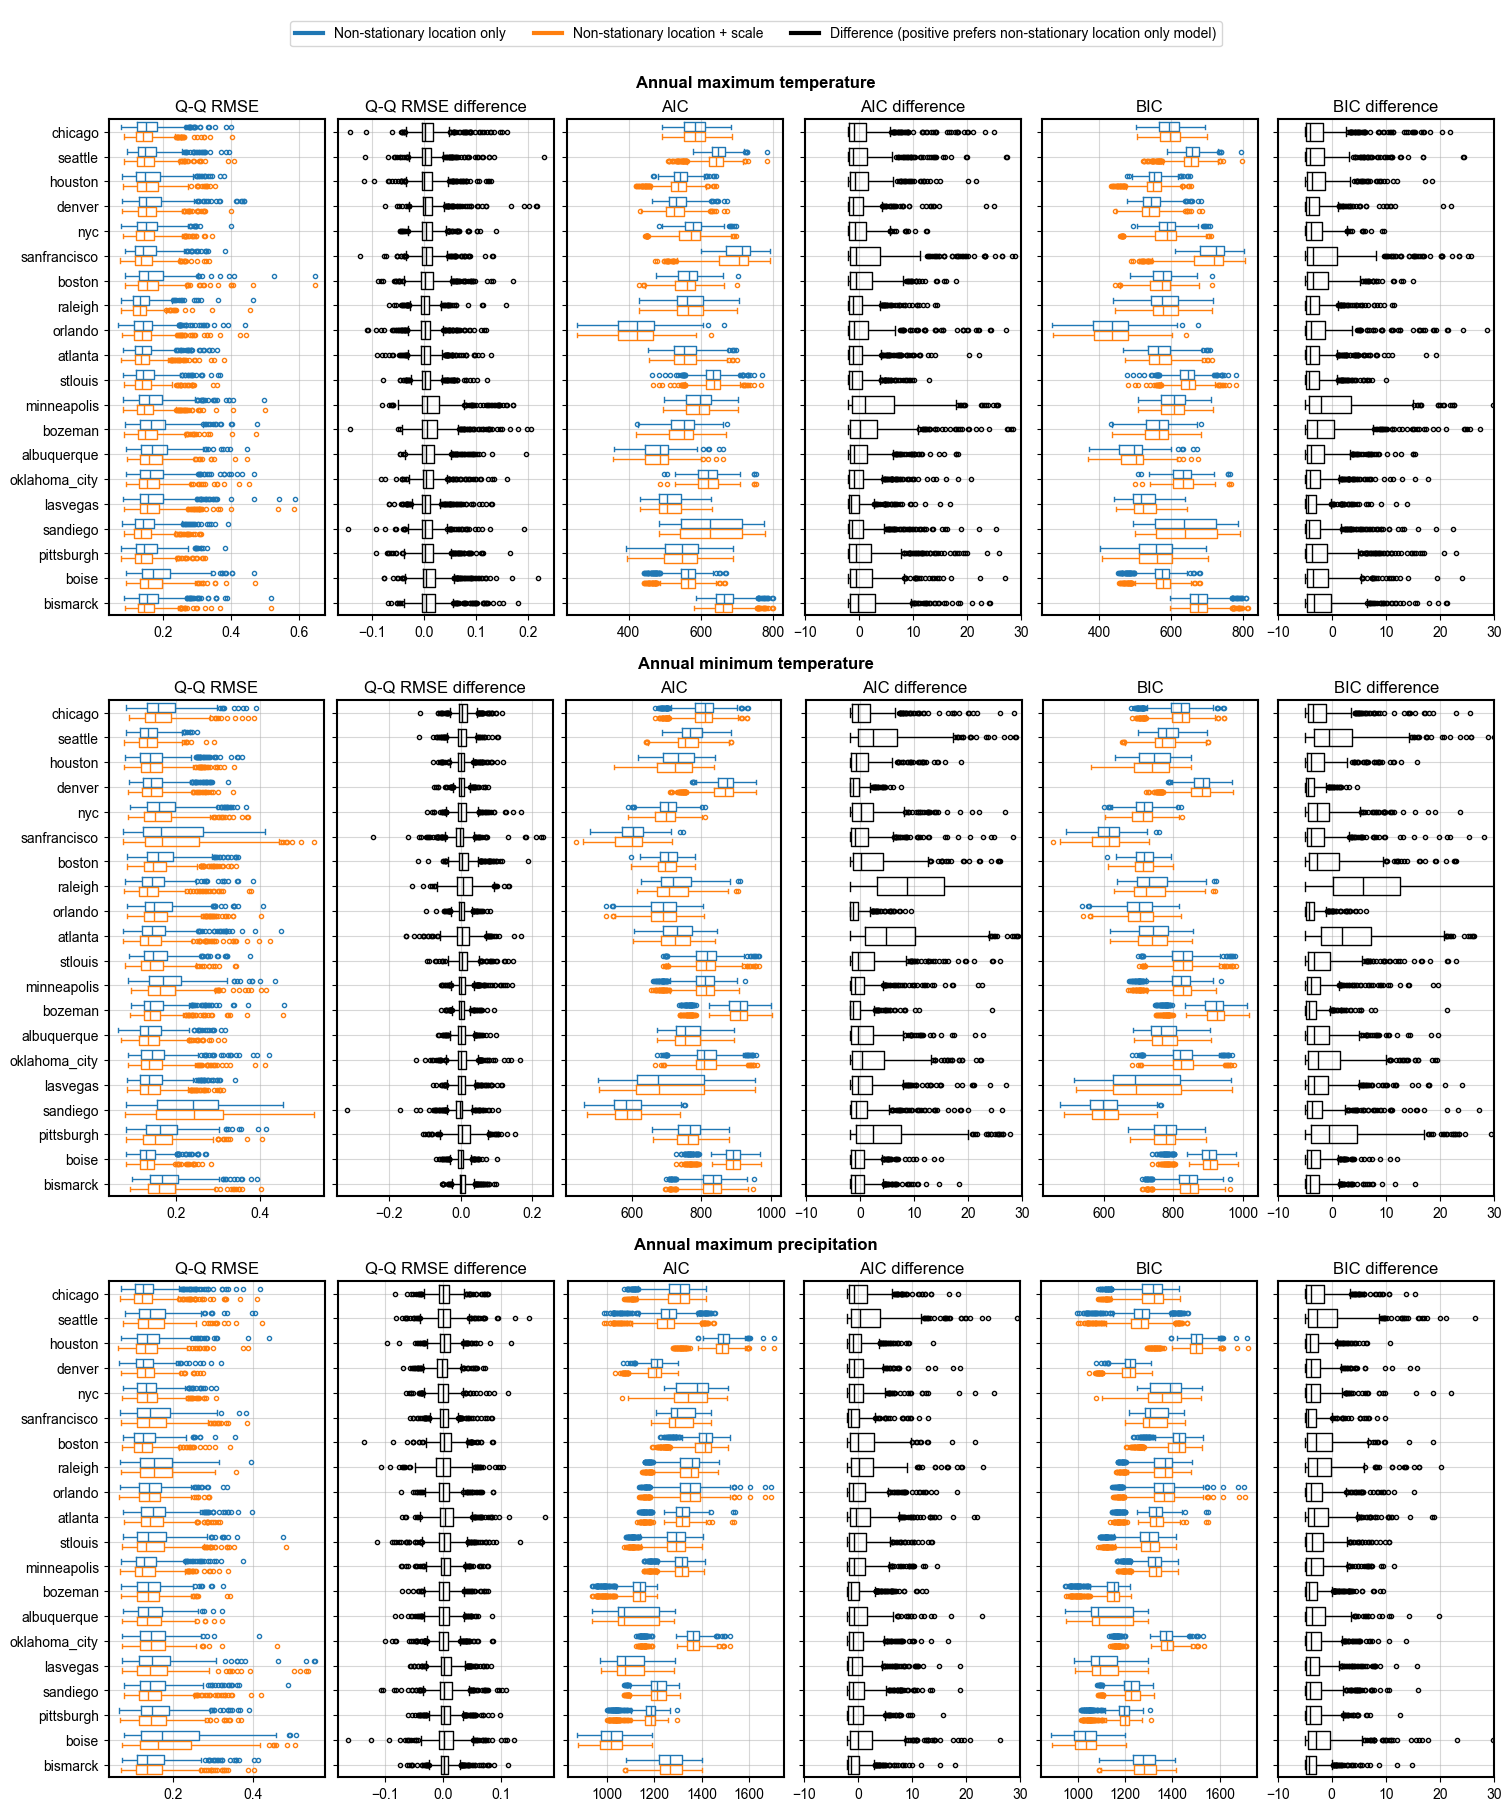

In [63]:
def plot_all(axs, data, data_merged):
    sns.boxplot(data=data, y='city', x='qq_rmse', hue='gev_type', ax=axs[0], fill=False, gap=.1, linewidth=1, flierprops={"marker": "."}, legend=False)
    axs[0].set_title('Q-Q RMSE')
    sns.boxplot(data=data, y='city', x='aic', hue='gev_type', ax=axs[2], fill=False, gap=.1, linewidth=1, flierprops={"marker": "."}, legend=False)
    axs[2].set_title('AIC')
    sns.boxplot(data=data, y='city', x='bic', hue='gev_type', ax=axs[4], fill=False, gap=.1, linewidth=1, flierprops={"marker": "."}, legend=False)
    axs[4].set_title('BIC')

    sns.boxplot(data=data_merged, y='city', x='rmse_diff', ax=axs[1], fill=False, gap=.1, linewidth=1, flierprops={"marker": ".", "color":"black"}, linecolor='black', color="black")
    axs[1].set_title('Q-Q RMSE difference')
    sns.boxplot(data=data_merged, y='city', x='aic_diff', ax=axs[3], fill=False, gap=.1, linewidth=1, flierprops={"marker": ".", "color":"black"}, linecolor='black', color="black")
    axs[3].set_title('AIC difference')
    axs[3].set_xlim([-10,30])
    sns.boxplot(data=data_merged, y='city', x='bic_diff', ax=axs[5], fill=False, gap=.1, linewidth=1, flierprops={"marker": ".", "color":"black"}, linecolor='black', color="black")
    axs[5].set_title('BIC difference')
    axs[5].set_xlim([-10,30])

    for ax in axs:
        ax.grid(alpha=0.5)
        ax.set_xlabel('')
        ax.set_ylabel('')

# Plot all
fig = plt.figure(layout='constrained', figsize=(15, 18))
subfigs = fig.subfigures(4, 1, wspace=0.07, height_ratios = [1,10,10,10])

# Legend
ax = subfigs[0].subplots()
legend_elements = [Line2D([0], [0], color='C0', lw=3, label='Non-stationary location only'),
                   Line2D([0], [0], color='C1', lw=3, label='Non-stationary location + scale'),
                   Line2D([0], [0], color='black', lw=3, label='Difference (positive prefers non-stationary location only model)')]
ax.legend(handles=legend_elements, loc='center', ncols=3)
ax.axis('off')

# Max tasmax
axs = subfigs[1].subplots(1, 6, sharey=True)
data = df_stats[df_stats['metric_id'] == 'max_tasmax']
data_merged = df_stats_merged[df_stats_merged['metric_id'] == 'max_tasmax']
plot_all(axs, data, data_merged)
subfigs[1].suptitle("Annual maximum temperature", fontweight='bold')

# Min tasmin
axs = subfigs[2].subplots(1, 6, sharey=True)
data = df_stats[df_stats['metric_id'] == 'min_tasmin']
data_merged = df_stats_merged[df_stats_merged['metric_id'] == 'min_tasmin']
plot_all(axs, data, data_merged)
subfigs[2].suptitle("Annual minimum temperature", fontweight='bold')

# Max pr
axs = subfigs[3].subplots(1, 6, sharey=True)
data = df_stats[df_stats['metric_id'] == 'max_pr']
data_merged = df_stats_merged[df_stats_merged['metric_id'] == 'max_pr']
plot_all(axs, data, data_merged)
subfigs[3].suptitle("Annual maximum precipitation", fontweight='bold')

plt.savefig(f'{project_code_path}/figs/si_city_nonstat_gev_evals.pdf', bbox_inches='tight')